<a href="https://colab.research.google.com/github/eycooper/CovidHesitancy/blob/main/Data_Load_and_Initial_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#Open Drive to access file content

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read in Data

vacc_hes = pd.read_csv('/content/drive/MyDrive/DS5100/vacc_hes_by_county.csv')
county_election = pd.read_csv('/content/drive/MyDrive/DS5100/County_level_election.csv')

In [ ]:
vacc_hes.head()
vacc_hes.dtypes

FIPS Code                                                             int64
County Name                                                          object
State                                                                object
Estimated hesitant                                                  float64
Estimated hesitant or unsure                                        float64
Estimated strongly hesitant                                         float64
Social Vulnerability Index (SVI)                                    float64
SVI Category                                                         object
CVAC level of concern for vaccination rollout                       float64
CVAC Level Of Concern                                                object
Percent adults fully vaccinated against COVID-19 (as of 6/10/21)    float64
Percent Hispanic                                                    float64
Percent non-Hispanic American Indian/Alaska Native                  float64
Percent non-

In [ ]:
county_election.head()

,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips,Unnamed: 10
0,93003,130413,246588,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2013,NaN
1,93003,130413,246588,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2016,NaN
2,93003,130413,246588,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2020,NaN
3,93003,130413,246588,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2050,NaN
4,93003,130413,246588,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2060,NaN


In [ ]:
#Aggregate Data

final_df = pd.merge(vacc_hes, county_election, how="left", left_on="FIPS Code", right_on="combined_fips")

final_df['political_affiliation'] = np.where(final_df['per_dem'] > final_df['per_gop'], "Democrat", "Republican")

final_df.head()

,FIPS Code,County Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,Percent adults fully vaccinated against COVID-19 (as of 6/10/21),Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips,Unnamed: 10,political_affiliation
0,1123,"Tallapoosa County, Alabama",ALABAMA,0.1806,0.2400,0.1383,0.89,Very High Vulnerability,0.64,High Concern,0.305,0.0242,0.0022,0.0036,0.2697,0.0000,0.6887,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-85.841259 33.104456, -85.8409...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",5271.0,12967.0,18504.0,0.284857,0.700767,"7,696",41.59%,AL,Tallapoosa County,1123.0,NaN,Republican
1,1121,"Talladega County, Alabama",ALABAMA,0.1783,0.2350,0.1368,0.87,Very High Vulnerability,0.84,Very High Concern,0.265,0.0229,0.0043,0.0061,0.3237,0.0003,0.6263,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-86.303069 33.46316, -86.30306...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",12108.0,20596.0,33218.0,0.364501,0.620025,"8,488",25.55%,AL,Talladega County,1121.0,NaN,Republican
2,1131,"Wilcox County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.93,Very High Vulnerability,0.94,Very High Concern,0.394,0.0053,0.0009,0.0003,0.6938,0.0000,0.2684,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.52534299999999 32.132773, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",4329.0,1737.0,6095.0,0.710254,0.284988,"2,592",42.53%,AL,Wilcox County,1131.0,NaN,Democrat
3,1129,"Washington County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.73,High Vulnerability,0.82,Very High Concern,0.308,0.0146,0.0731,0.0025,0.2354,0.0000,0.6495,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-88.45317899999999 31.505388, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",2366.0,6031.0,8492.0,0.278615,0.710198,"3,665",43.16%,AL,Washington County,1129.0,NaN,Republican
4,1133,"Winston County, Alabama",ALABAMA,0.1805,0.2313,0.1379,0.70,High Vulnerability,0.80,High Concern,0.163,0.0315,0.0034,0.0016,0.0073,0.0005,0.9370,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.63656399999999 34.120908, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",871.0,9225.0,10255.0,0.084934,0.899561,"8,354",81.46%,AL,Winston County,1133.0,NaN,Republican


In [ ]:
#Data Pre-processing

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def convert(data):
    number = preprocessing.LabelEncoder()
    float_cols_vec = [3,4,5,6,8,10,11,12,13,14,15,16,22,23,24,25]
    #[3,4,5,6,8,10,11,12,13,14,15,16,17,22,23,24,25,26,27]
    float_cols = np.array(final_df.columns)[float_cols_vec]
    for i in float_cols:
      data[i] = pd.to_numeric(data[i],errors='coerce')
    data=data.fillna(0)
    return data

final_df_processed=convert(final_df)


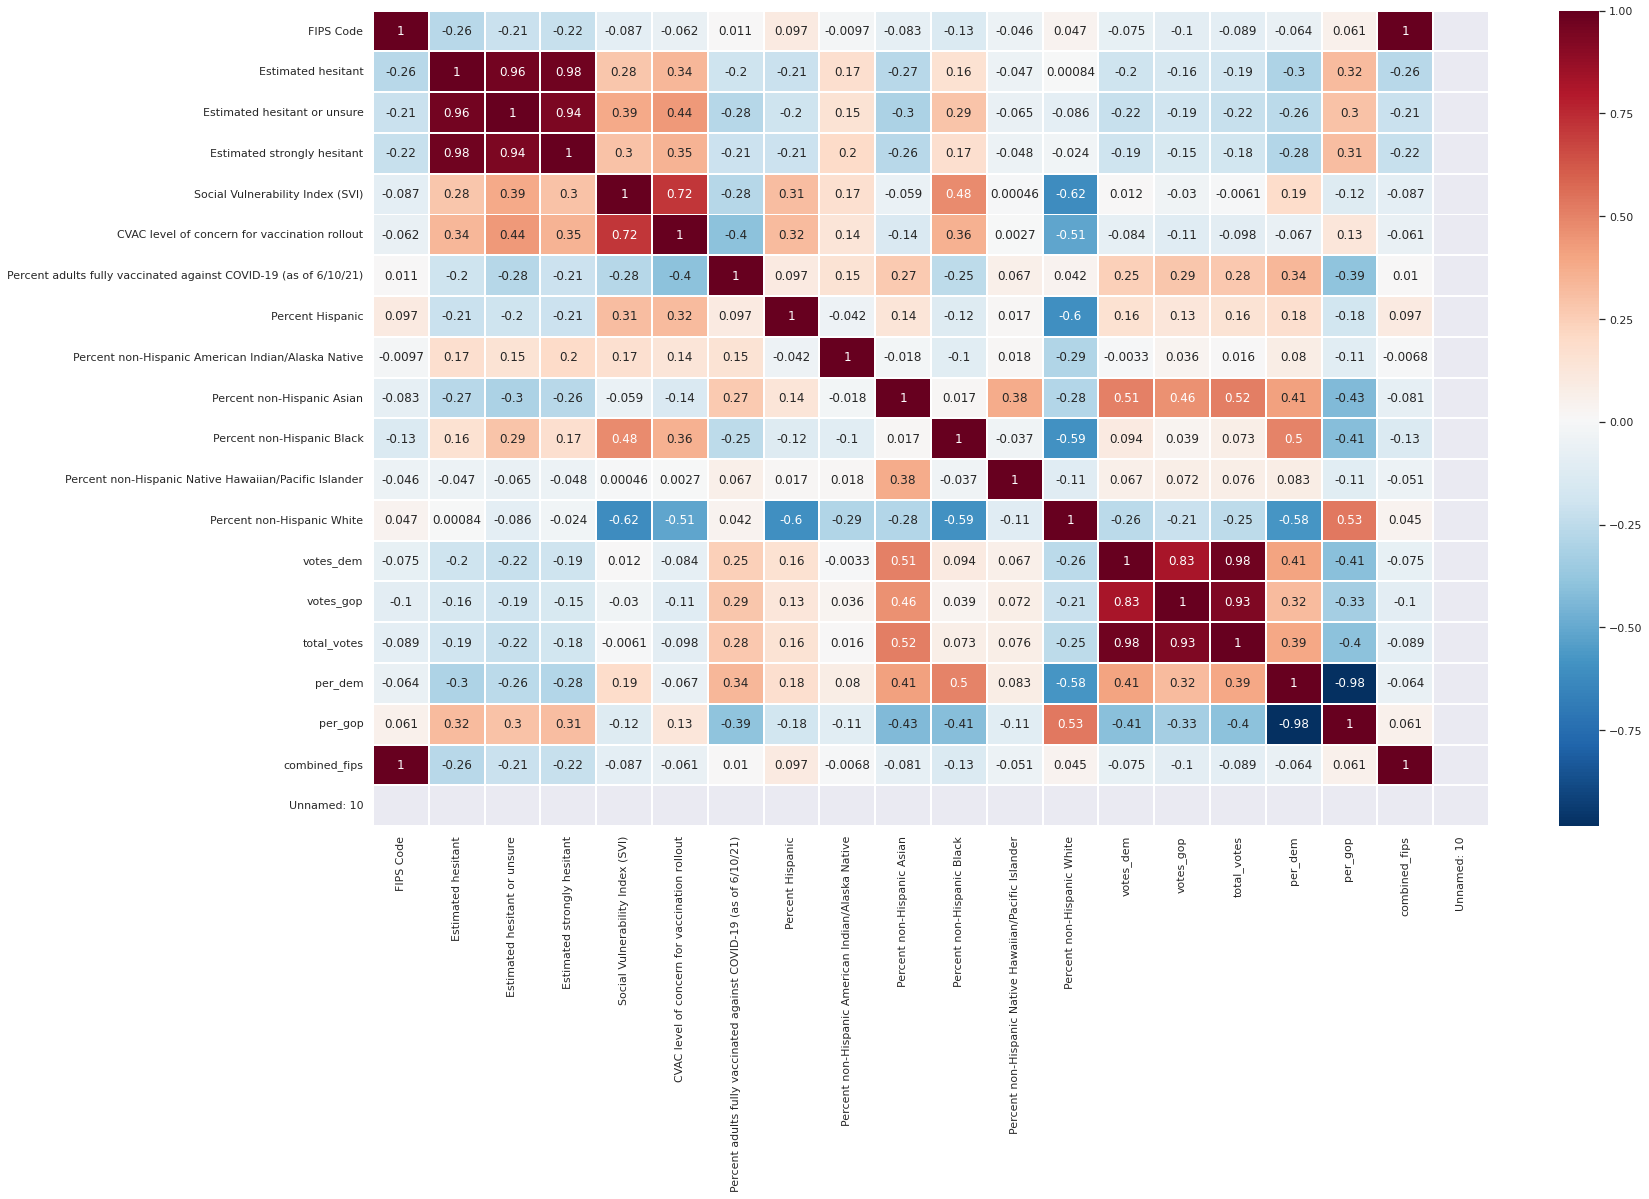

In [ ]:
#Set Predictor columns by index number and look at correlation matrix

import seaborn as sns
predictor_cols=[6, 10, 11,12,13,14,15,16,24,25]

corr_matrix = final_df.corr()
# corr_matrix.head()

sns.set(rc = {'figure.figsize':(25,15)})
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=1)

In [ ]:
#Set matrix with desired columns

col_names=[3, 4, 5, 10, 11, 13, 14, 24, 25, 32]
np.array(final_df.columns)[col_names]

array(['Estimated hesitant', 'Estimated hesitant or unsure',
       'Estimated strongly hesitant',
       'Percent adults fully vaccinated against COVID-19 (as of 6/10/21)',
       'Percent Hispanic', 'Percent non-Hispanic Asian',
       'Percent non-Hispanic Black', 'per_dem', 'per_gop',
       'political_affiliation'], dtype=object)

In [ ]:
#Aggregate data by state

by_state= final_df.groupby(['State'])[np.array(final_df.columns)[col_names]].mean().reset_index()
Est_hes_corr = by_state.corr().iloc[0]
by_state.head()

,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Percent adults fully vaccinated against COVID-19 (as of 6/10/21),Percent Hispanic,Percent non-Hispanic Asian,Percent non-Hispanic Black,per_dem,per_gop
0,ALABAMA,0.173507,0.231512,0.132409,0.320851,0.034864,0.007072,0.287355,0.337876,0.644119
1,ALASKA,0.217386,0.264245,0.156907,0.582296,0.053148,0.053886,0.013293,0.377159,0.528870
2,ARIZONA,0.159240,0.242547,0.121353,0.504733,0.313380,0.013267,0.018427,0.419269,0.528055
3,ARKANSAS,0.212123,0.261232,0.139901,0.338800,0.052561,0.006661,0.160659,0.306559,0.653989
4,CALIFORNIA,0.072274,0.111041,0.035807,0.506820,0.306224,0.073066,0.029845,0.503740,0.433299


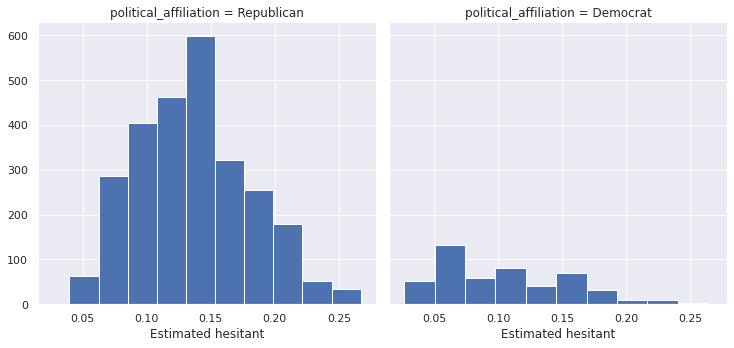

In [ ]:
#Plot Estimated hesitant, broken up by political affiliation

import matplotlib.pyplot as plt

sns.set(style = "darkgrid")
by_state['political_affiliation'] = np.where(by_state['per_dem'] > by_state['per_gop'], "Democrat", "Republican")

by_state.head()

g = sns.FacetGrid(final_df, col="political_affiliation", col_wrap=5, height=5, palette="deep")
g = g.map(plt.hist, "Estimated hesitant")

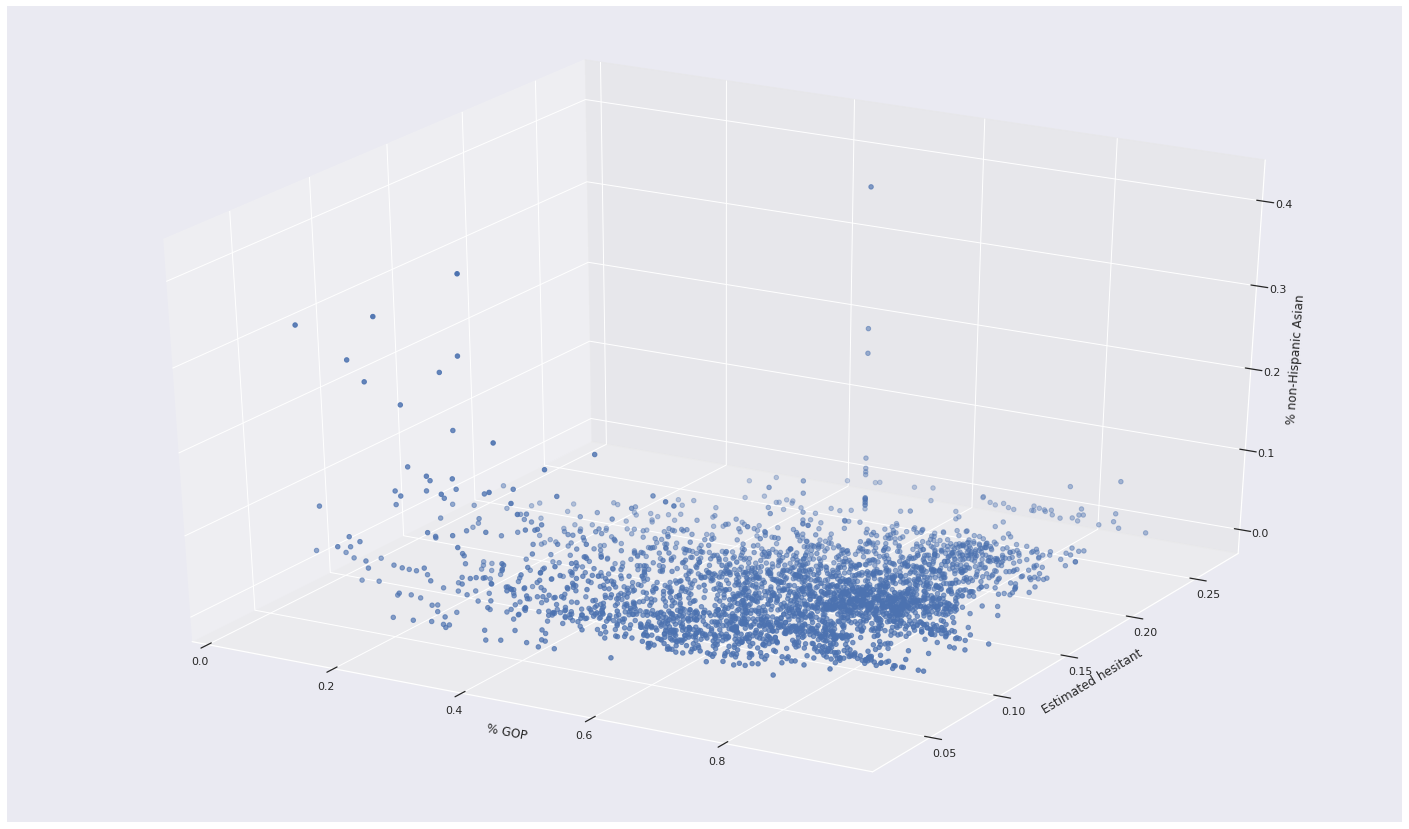

In [ ]:
#3d plot with percent GOP, Estimated Hesitant, and % non-Hispanic Asian

from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = final_df['per_gop']
y = final_df['Estimated hesitant']
z = final_df['Percent non-Hispanic Asian']

ax.set_xlabel("% GOP")
ax.set_ylabel("Estimated hesitant")
ax.set_zlabel('% non-Hispanic Asian')

ax.scatter(x, y, z)

plt.show()

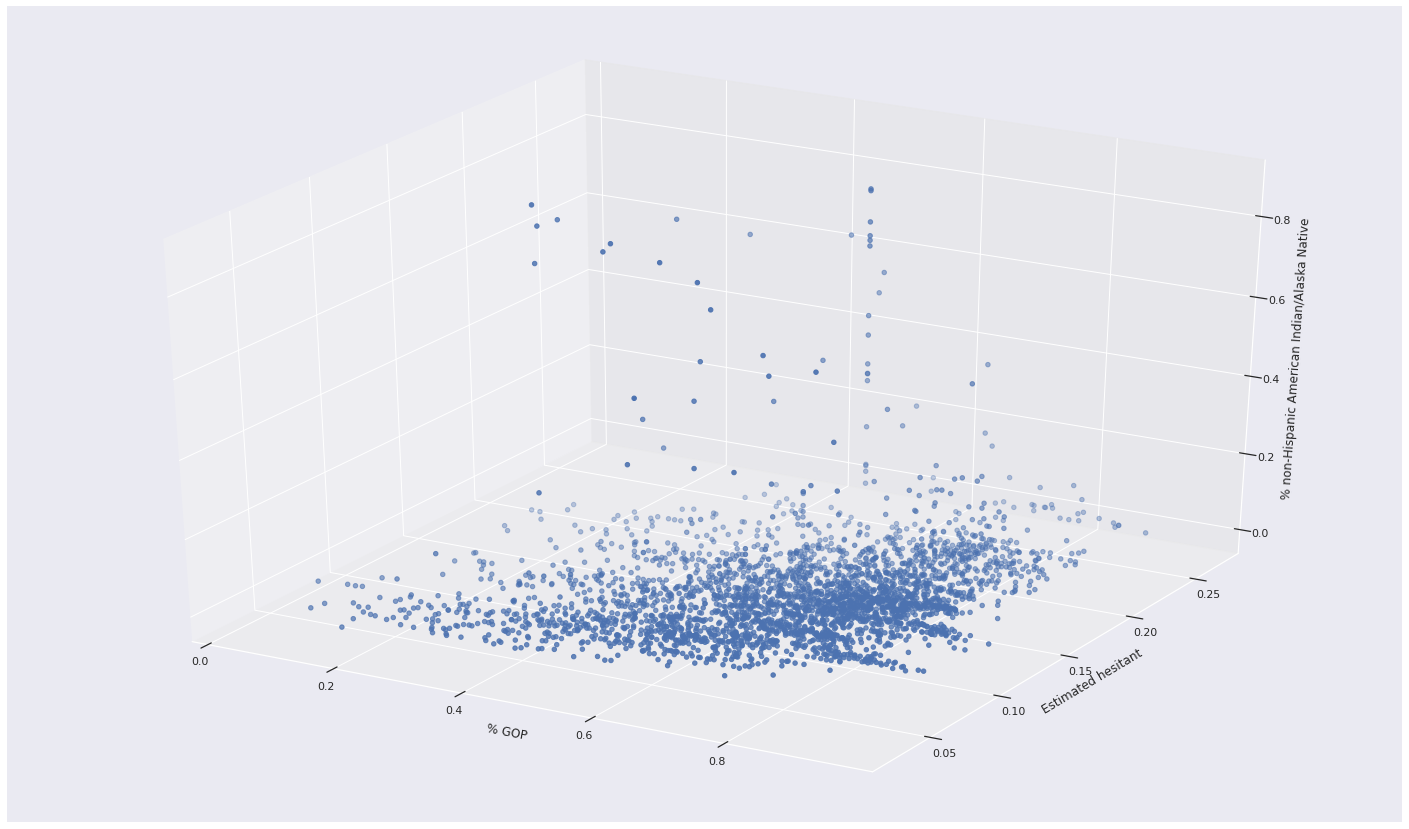

In [ ]:
#3d plot with percent GOP, Estimated Hesitant, and % non-Hispanic American Indian/Alaska Native

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = final_df['per_gop']
y = final_df['Estimated hesitant']
z = final_df['Percent non-Hispanic American Indian/Alaska Native']

ax.set_xlabel("% GOP")
ax.set_ylabel("Estimated hesitant")
ax.set_zlabel('% non-Hispanic American Indian/Alaska Native')

ax.scatter(x, y, z)

plt.show()

In [ ]:
#Train Regression Model On Full Data Set
from sklearn.linear_model import LinearRegression

x=np.array(final_df['per_gop'])
y=np.array(final_df['Estimated hesitant'])

x=np.nan_to_num(x)
y=np.nan_to_num(y)

x= x.reshape(-1, 1)
y= y.reshape(-1, 1)

model = LinearRegression(fit_intercept =True).fit(x, y)

model.score(x, y)

0.10245560543690757

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(alpha=0.75,
              ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f14f52028d0>,
              hist=True, line_color=None, model=None, test_color=None,
              train_color=None)

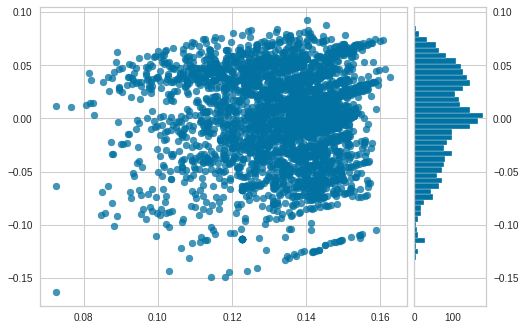

In [ ]:
#Plot Residuals
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model)
visualizer.fit(x, y)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


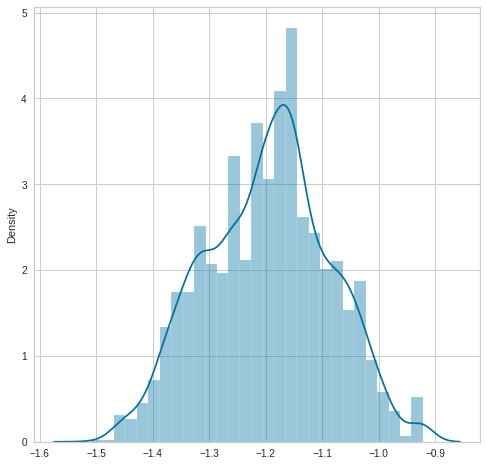

In [ ]:
#Transformation
from scipy import stats

prediction = model.predict(x)
residual = np.array(y - prediction)
residual


tdata = stats.boxcox(y.flatten())[0]
plt.figure(figsize = (8, 8))
sns.distplot(tdata)
plt.show()

In [ ]:
## Lambda value of -1 suggests transformation y_star=1/y
y_star = 1/y

model2 = LinearRegression(fit_intercept =True).fit(x, y_star)

model2.score(x, y_star)

0.1716250982542582

In [ ]:
print("beta_0 (intercept value): ", model2.intercept_)
print("beta_1 (slope value): ", model2.coef_)

beta_0 (intercept value):  [15.03321338]
beta_1 (slope value):  [[-9.96173623]]


In [ ]:
#Use data aggregated by state, with equal weight per county
x=np.array(by_state['per_gop'])
y=np.array(by_state['Estimated hesitant'])

x=np.nan_to_num(x)
y=np.nan_to_num(y)

x= x.reshape(-1, 1)
y= y.reshape(-1, 1)

model3 = LinearRegression().fit(x, y)

model3.score(x, y)

0.36214321596080934

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



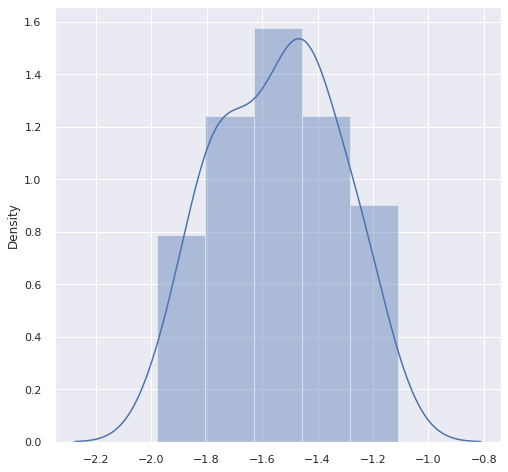

In [ ]:
#Transformation for model using State aggregated data

prediction = model.predict(x)
residual = np.array(y - prediction)
residual


tdata = stats.boxcox(y.flatten())[0]
plt.figure(figsize = (8, 8))
sns.distplot(tdata)
plt.show()

In [ ]:
#Update model to use transformed y

y_star = 1/y

model4 = LinearRegression().fit(x, y_star)

model4.score(x, y_star)

0.48521195992788574

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

predictor_cols=[6, 10, 11,12,13,14,15,16,24,25]

X = final_df_processed[np.array(final_df_processed.columns)[predictor_cols]]
y = final_df_processed['Estimated hesitant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor()
# Train the model on training data
rf.fit(X_train, y_train);


#Observe predictions
y_pred=rf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.0240732308958885
Mean Squared Error: 0.0009991014450123495
Root Mean Squared Error: 0.031608566006896766


In [ ]:
#Access Random Forest Feature Importance

feature_importance = rf.feature_importances_
col_names = np.array(final_df.columns)[predictor_cols]

feat_importance_matrix = pd.DataFrame(
    {'Column Names': col_names,
     'Feature Importance': feature_importance
    })

feat_importance_matrix.sort_values(['Feature Importance'], ascending=False)

,Column Names,Feature Importance
1,Percent adults fully vaccinated against COVID-...,0.165038
9,per_gop,0.134657
0,Social Vulnerability Index (SVI),0.123988
3,Percent non-Hispanic American Indian/Alaska Na...,0.110503
2,Percent Hispanic,0.108763
5,Percent non-Hispanic Black,0.105746
8,per_dem,0.084330
4,Percent non-Hispanic Asian,0.071959
7,Percent non-Hispanic White,0.067178
6,Percent non-Hispanic Native Hawaiian/Pacific I...,0.027837


## Notable insights
Percent GOP has a higher feature importance than any other variable outside of % of adults fully vaccinated against COVID (which this variable seems to make sense as the highest predictor because they are directly correlated). 

Interesting how some race percentage variables are significantly higher than others, like Black, Hispanic, and Indian/Native.


In [ ]:
!pip install geopandas
!pip install geoplot
!pip install pysal
!pip install plotly

     |████████████████████████████████| 1.0 MB 5.9 MB/s 
     |████████████████████████████████| 6.3 MB 69.7 MB/s 
     |████████████████████████████████| 15.4 MB 35 kB/s 
     |████████████████████████████████| 10.8 MB 26 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 61.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 20.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 219 kB 41.3 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516238 sha256=750e1f623767d2cb1c166a8d79c6ce524d42daa9da61f440937d308e9e388749
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10

In [ ]:
%matplotlib inline

import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import pathlib
import mapclassify as mc
from shapely import wkt

usa = gpd.read_file('/content/drive/MyDrive/DS5100/cb_2018_us_state_20m.shp')
usa = usa.rename(columns = {'NAME' : 'State'}, inplace = False)
usa["State"] = usa["State"].str.upper() 

pop_states = usa.merge(by_state, left_on="State", right_on="State")
print(pop_states.dtypes)

# pop_states[pop_states.State=="ALABAMA"].plot()
# pop_states.plot()
# gplt.polyplot(pop_states, facecolor="dodgerblue", edgecolor="lightgrey", figsize=(30,20));

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


DriverError: ignored

In [ ]:
gplt.choropleth(pop_states, hue="Estimated hesitant", cmap="Greens",figsize=(30,20), legend = True, legend_kwargs={'shrink': 0.2})

NameError: ignored

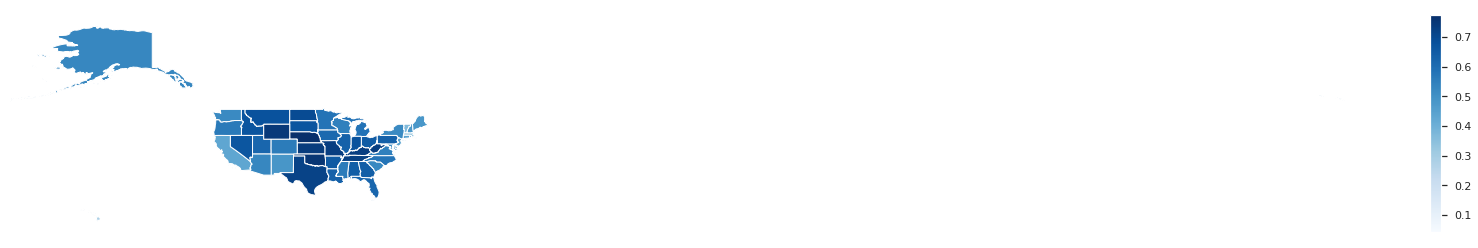

In [ ]:
gplt.choropleth(pop_states, hue="per_gop", cmap="Blues",figsize=(30,20), legend = True, legend_kwargs={'shrink': 0.2})

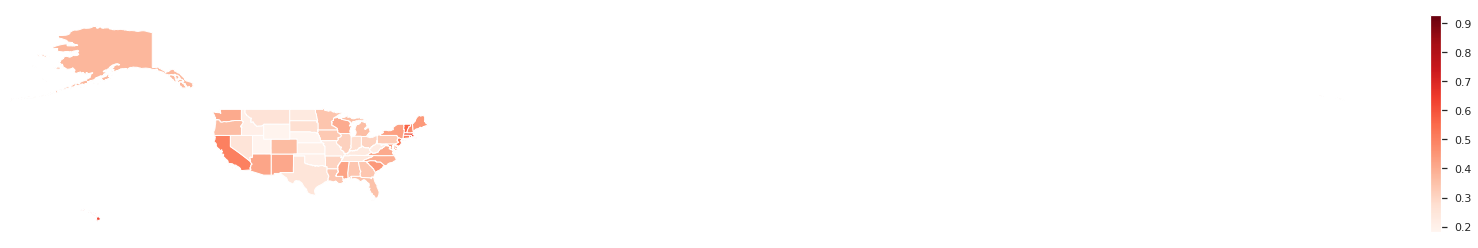

In [ ]:
gplt.choropleth(pop_states, hue="per_dem", cmap="Reds",figsize=(30,20), legend = True, legend_kwargs={'shrink': 0.2})

In [ ]:
import plotly.express as px

fig = px.bar(pop_states, x="State", y="Estimated hesitant", color="Percent adults fully vaccinated against COVID-19 (as of 6/10/21)")
fig.show()

In [ ]:
final_df.dtypes

FIPS Code                                                             int64
County Name                                                          object
State                                                                object
Estimated hesitant                                                  float64
Estimated hesitant or unsure                                        float64
Estimated strongly hesitant                                         float64
Social Vulnerability Index (SVI)                                    float64
SVI Category                                                         object
CVAC level of concern for vaccination rollout                       float64
CVAC Level Of Concern                                                object
Percent adults fully vaccinated against COVID-19 (as of 6/10/21)    float64
Percent Hispanic                                                    float64
Percent non-Hispanic American Indian/Alaska Native                  float64
Percent non-

In [ ]:
px.scatter(final_df,
          x="Social Vulnerability Index (SVI)",
          y="Estimated hesitant",
          color="political_affiliation",
          hover_name="State",
          trendline="lowess",
          title="Scatter plot with histogram and box marginal plot and two trendlines")

In [ ]:
px.pie(pop_states, names="State", values="Estimated strongly hesitant")